# RQ2: Per-Repository Case Studies Analysis

This notebook performs the complete RQ2 analysis as described in the paper:

1. **Filtering**: Apply filters (closed, license, feedback before closure)
2. **Repository Selection**: Select two groups of 50 repositories:
   - Top 50 by GitHub stars (high-visibility projects)
   - Top 50 by PR count (high AI-activity projects)
3. **Analysis**:
   - Acceptance rates with mean ± std
   - Related issue analysis
   - Task type analysis
   - Agent distribution

**Expected results from paper:**
- Stars-based: 50 repos, 669 PRs, 51.2% ± 38.0% acceptance
- PR-based: 50 repos, 3,622 PRs, 69.2% ± 22.6% acceptance

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("Setup complete!")

Setup complete!


## 2. Constants

In [2]:
# AI Agents in the dataset
AGENTS = ["Human", "OpenAI_Codex", "Devin", "Copilot", "Cursor", "Claude_Code"]

AGENT_DISPLAY_NAMES = {
    "Human": "Human",
    "OpenAI_Codex": "OpenAI Codex",
    "Devin": "Devin",
    "Copilot": "Copilot",
    "Cursor": "Cursor",
    "Claude_Code": "Claude Code",
}

# Task types (Conventional Commits)
TASK_TYPE_ORDER = [
    "feat", "fix", "perf", "refactor", "style",
    "docs", "test", "chore", "build", "ci", "revert", "other"
]

# Task type mapping for paper display
TASK_TYPE_DISPLAY = {
    "feat": "New feature",
    "fix": "Bug fix",
    "docs": "Documentation",
    "chore": "Chore",
    "perf": "Performance",
    "refactor": "Refactor",
    "style": "Other*",
    "test": "Other*",
    "build": "Other*",
    "ci": "Other*",
    "revert": "Other*",
    "other": "Other*",
}

# Colors for visualizations
COLOR_MAP = {
    "Human": "#56B4E9",
    "OpenAI_Codex": "#D55E00",
    "Devin": "#009E73",
    "Copilot": "#0072B2",
    "Cursor": "#785EF0",
    "Claude_Code": "#DC267F",
}

OUTCOME_COLORS = {
    "accepted": "#4ECDC4",
    "rejected": "#FF6B6B",
}

## 3. Retrieve Filtered Dataset

We apply three filters:
1. **Closed PRs only**: Exclude open PRs
2. **License filter**: Only MIT or Apache-2.0 licensed repositories
3. **Feedback filter**: Only PRs with at least one non-creator comment/review before closure

In [3]:
filtered_df = pd.read_csv('data/filtered/pull_request.csv')
related_issue_df = pd.read_csv('data/filtered/related_issue.csv')
repo_df = pd.read_csv('data/filtered/repository.csv')
pr_task_type_df = pd.read_csv('data/filtered/pr_task_type.csv')

## 6. Repository Selection

We select two groups of 50 repositories:
1. **Top 50 by GitHub Stars** (high-visibility projects)
2. **Top 50 by PR Count** (high AI-activity projects)

### 6.1 Top 50 by GitHub Stars

In [4]:
# Get repos that have PRs in filtered dataset
repos_in_filtered = filtered_df['repo_id'].unique()
repos_available = repo_df[repo_df['id'].isin(repos_in_filtered)].copy()

print(f"Repositories with PRs in filtered dataset: {len(repos_available)}")

# Count PRs per repo
pr_counts = filtered_df.groupby('repo_id').size().reset_index(name='pr_count')
repos_available = repos_available.merge(pr_counts, left_on='id', right_on='repo_id', how='left')

# Determine star column name
star_col = 'stargazers_count' if 'stargazers_count' in repos_available.columns else 'stars'

# Sort by stars and get top 50
top_by_stars = repos_available.nlargest(50, star_col)

print(f"\nTop 50 repositories by stars:")
print(f"  Stars range: {top_by_stars[star_col].min():,} to {top_by_stars[star_col].max():,}")
print(f"  PR count range: {top_by_stars['pr_count'].min()} to {top_by_stars['pr_count'].max()}")

Repositories with PRs in filtered dataset: 1054

Top 50 repositories by stars:
  Stars range: 26,945 to 175,171
  PR count range: 1 to 260


In [5]:
# Show top 10 by stars
print("Top 10 repositories by stars:")
for i, (_, row) in enumerate(top_by_stars.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['full_name']:45s} {row[star_col]:>8,} stars, {row['pr_count']:3.0f} PRs")

Top 10 repositories by stars:
   1. microsoft/vscode                               175,171 stars,  92 PRs
   2. vercel/next.js                                 133,524 stars,   4 PRs
   3. microsoft/PowerToys                            121,672 stars,   5 PRs
   4. langchain-ai/langchain                         112,624 stars,   5 PRs
   5. microsoft/TypeScript                           105,450 stars,  15 PRs
   6. ant-design/ant-design                           95,512 stars,   6 PRs
   7. langflow-ai/langflow                            93,294 stars,   3 PRs
   8. supabase/supabase                               86,399 stars,   1 PRs
   9. nvm-sh/nvm                                      86,116 stars,   2 PRs
  10. bitcoin/bitcoin                                 84,827 stars,   2 PRs


In [6]:
# Filter PRs to top 50 by stars
stars_pr_df = filtered_df[filtered_df['repo_id'].isin(top_by_stars['id'])].copy()

print(f"\nPRs in top 50 by stars: {len(stars_pr_df):,}")


PRs in top 50 by stars: 669


### 6.2 Top 50 by PR Count

In [7]:
# Sort by PR count and get top 50
top_by_prs = repos_available.nlargest(50, 'pr_count')

print(f"Top 50 repositories by PR count:")
print(f"  PR count range: {top_by_prs['pr_count'].min():.0f} to {top_by_prs['pr_count'].max():.0f}")
print(f"  Stars range: {top_by_prs[star_col].min():,} to {top_by_prs[star_col].max():,}")

Top 50 repositories by PR count:
  PR count range: 29 to 343
  Stars range: 116 to 175,171


In [8]:
# Show top 10 by PR count
print("Top 10 repositories by PR count:")
for i, (_, row) in enumerate(top_by_prs.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['full_name']:45s} {row['pr_count']:3.0f} PRs, {row[star_col]:>8,} stars")

Top 10 repositories by PR count:
   1. liam-hq/liam                                  343 PRs,    4,194 stars
   2. crewAIInc/crewAI                              260 PRs,   35,096 stars
   3. antiwork/helper                               167 PRs,      537 stars
   4. MontrealAI/AGI-Alpha-Agent-v0                 164 PRs,      251 stars
   5. antiwork/flexile                              153 PRs,      665 stars
   6. giselles-ai/giselle                           139 PRs,      154 stars
   7. dotnet/aspire                                 132 PRs,    4,723 stars
   8. antiwork/gumroad                              120 PRs,    6,643 stars
   9. promptfoo/promptfoo                            98 PRs,    7,809 stars
  10. onlook-dev/onlook                              94 PRs,   21,192 stars


In [9]:
# Filter PRs to top 50 by PR count
prs_pr_df = filtered_df[filtered_df['repo_id'].isin(top_by_prs['id'])].copy()

print(f"\nPRs in top 50 by PR count: {len(prs_pr_df):,}")


PRs in top 50 by PR count: 3,622


## 7. Acceptance Rate Analysis

In [10]:
def compute_acceptance_stats(pr_df, top_repos):
    """Compute acceptance rate statistics for a set of repositories."""
    results = []
    
    for _, repo in top_repos.iterrows():
        repo_prs = pr_df[pr_df['repo_id'] == repo['id']]
        total = len(repo_prs)
        accepted = repo_prs['accepted'].sum()
        rejected = repo_prs['rejected'].sum()
        
        acc_rate = (accepted / total * 100) if total > 0 else 0
        
        results.append({
            'repo_name': repo['full_name'],
            'repo_id': repo['id'],
            'total': total,
            'accepted': int(accepted),
            'rejected': int(rejected),
            'acceptance_rate': acc_rate
        })
    
    df = pd.DataFrame(results)
    
    # Aggregate statistics
    total_prs = df['total'].sum()
    total_accepted = df['accepted'].sum()
    overall_rate = total_accepted / total_prs * 100 if total_prs > 0 else 0
    
    # Mean and std of per-repo acceptance rates
    mean_rate = df['acceptance_rate'].mean()
    std_rate = df['acceptance_rate'].std()
    
    return {
        'per_repo_df': df,
        'total_repos': len(df),
        'total_prs': int(total_prs),
        'total_accepted': int(total_accepted),
        'total_rejected': int(df['rejected'].sum()),
        'overall_acceptance_rate': overall_rate,
        'mean_acceptance_rate': mean_rate,
        'std_acceptance_rate': std_rate,
    }

### 7.1 Acceptance Rates - Top by Stars

In [11]:
stars_stats = compute_acceptance_stats(stars_pr_df, top_by_stars)

print("TOP 50 BY STARS - Acceptance Statistics")
print("="*50)
print(f"Repositories: {stars_stats['total_repos']}")
print(f"Total PRs: {stars_stats['total_prs']:,}")
print(f"Accepted: {stars_stats['total_accepted']:,}")
print(f"Rejected: {stars_stats['total_rejected']:,}")
print(f"")
print(f"Acceptance Rate: {stars_stats['mean_acceptance_rate']:.1f}% ± {stars_stats['std_acceptance_rate']:.1f}%")
print(f"Overall Rate: {stars_stats['overall_acceptance_rate']:.1f}%")

TOP 50 BY STARS - Acceptance Statistics
Repositories: 50
Total PRs: 669
Accepted: 278
Rejected: 391

Acceptance Rate: 51.2% ± 38.0%
Overall Rate: 41.6%


In [12]:
# Show per-repo breakdown
stars_stats['per_repo_df'].sort_values('acceptance_rate', ascending=False).head(10)

,repo_name,repo_id,total,accepted,rejected,acceptance_rate
49,microsoft/graphrag,778431525,3,3,0,100.0
8,nvm-sh/nvm,612230,2,2,0,100.0
17,astral-sh/uv,699532645,3,3,0,100.0
24,usememos/memos,436297812,1,1,0,100.0
29,gradio-app/gradio,162405963,1,1,0,100.0
11,opencv/opencv,5108051,2,2,0,100.0
20,unclecode/crawl4ai,798201435,6,6,0,100.0
37,docling-project/docling,826168160,4,4,0,100.0
42,transloadit/uppy,46273445,4,4,0,100.0
44,apolloconfig/apollo,53127403,1,1,0,100.0


### 7.2 Acceptance Rates - Top by PRs

In [13]:
prs_stats = compute_acceptance_stats(prs_pr_df, top_by_prs)

print("TOP 50 BY PR COUNT - Acceptance Statistics")
print("="*50)
print(f"Repositories: {prs_stats['total_repos']}")
print(f"Total PRs: {prs_stats['total_prs']:,}")
print(f"Accepted: {prs_stats['total_accepted']:,}")
print(f"Rejected: {prs_stats['total_rejected']:,}")
print(f"")
print(f"Acceptance Rate: {prs_stats['mean_acceptance_rate']:.1f}% ± {prs_stats['std_acceptance_rate']:.1f}%")
print(f"Overall Rate: {prs_stats['overall_acceptance_rate']:.1f}%")

TOP 50 BY PR COUNT - Acceptance Statistics
Repositories: 50
Total PRs: 3,622
Accepted: 2,526
Rejected: 1,096

Acceptance Rate: 69.2% ± 22.6%
Overall Rate: 69.7%


In [14]:
# Show per-repo breakdown
prs_stats['per_repo_df'].sort_values('acceptance_rate', ascending=False).head(10)

,repo_name,repo_id,total,accepted,rejected,acceptance_rate
49,bruin-data/bruin,674225653,29,29,0,100.000000
3,MontrealAI/AGI-Alpha-Agent-v0,922805069,164,164,0,100.000000
26,theopenco/llmgateway,965250949,49,48,1,97.959184
41,gluesql/gluesql,227265548,35,34,1,97.142857
47,shinnku-nikaidou/shinnku-com,360211540,31,29,2,93.548387
11,prebid/Prebid.js,39321023,87,81,6,93.103448
13,GlareDB/glaredb,496817075,74,68,6,91.891892
7,antiwork/gumroad,959682770,120,110,10,91.666667
31,imbhargav5/rooks,156734327,45,41,4,91.111111
25,gofiber/fiber,234231371,50,45,5,90.000000


## 8. Related Issue Analysis

In [15]:
def compute_related_issue_stats(pr_df):
    """Compute acceptance rates by related issue presence."""
    with_issue = pr_df[pr_df['related_issue'] == True]
    without_issue = pr_df[pr_df['related_issue'] == False]
    
    total_with = len(with_issue)
    total_without = len(without_issue)
    
    acc_with = with_issue['accepted'].sum()
    acc_without = without_issue['accepted'].sum()
    
    rate_with = (acc_with / total_with * 100) if total_with > 0 else 0
    rate_without = (acc_without / total_without * 100) if total_without > 0 else 0
    
    return {
        'with_issue': {'total': total_with, 'accepted': int(acc_with), 'rate': rate_with},
        'without_issue': {'total': total_without, 'accepted': int(acc_without), 'rate': rate_without},
        'effect': rate_with - rate_without
    }

In [16]:
# Related issue analysis for Stars set
stars_issue = compute_related_issue_stats(stars_pr_df)

print("TOP 50 BY STARS - Related Issue Analysis")
print("="*50)
print(f"With related issue:    {stars_issue['with_issue']['total']:,} PRs, {stars_issue['with_issue']['rate']:.1f}% acceptance")
print(f"Without related issue: {stars_issue['without_issue']['total']:,} PRs, {stars_issue['without_issue']['rate']:.1f}% acceptance")
print(f"Effect: {stars_issue['effect']:+.1f}%")

TOP 50 BY STARS - Related Issue Analysis
With related issue:    337 PRs, 41.2% acceptance
Without related issue: 332 PRs, 41.9% acceptance
Effect: -0.6%


In [17]:
# Related issue analysis for PRs set
prs_issue = compute_related_issue_stats(prs_pr_df)

print("TOP 50 BY PR COUNT - Related Issue Analysis")
print("="*50)
print(f"With related issue:    {prs_issue['with_issue']['total']:,} PRs, {prs_issue['with_issue']['rate']:.1f}% acceptance")
print(f"Without related issue: {prs_issue['without_issue']['total']:,} PRs, {prs_issue['without_issue']['rate']:.1f}% acceptance")
print(f"Effect: {prs_issue['effect']:+.1f}%")

TOP 50 BY PR COUNT - Related Issue Analysis
With related issue:    799 PRs, 60.1% acceptance
Without related issue: 2,823 PRs, 72.5% acceptance
Effect: -12.4%


## 9. Task Type Analysis

In [18]:
def compute_task_type_stats(pr_df, task_type_df):
    """Compute acceptance rate by task type."""
    # Merge task types with PRs
    pr_with_task = pr_df.merge(
        task_type_df[['id', 'type']].rename(columns={'id': 'task_pr_id', 'type': 'task_type'}),
        left_on='id',
        right_on='task_pr_id',
        how='left'
    )
    pr_with_task['task_type'] = pr_with_task['task_type'].fillna('other')
    
    # Compute stats per task type
    results = []
    for task_type in TASK_TYPE_ORDER:
        task_prs = pr_with_task[pr_with_task['task_type'] == task_type]
        total = len(task_prs)
        if total > 0:
            accepted = task_prs['accepted'].sum()
            acc_rate = (accepted / total * 100)
            results.append({
                'task_type': task_type,
                'display_name': TASK_TYPE_DISPLAY[task_type],
                'total': total,
                'accepted': int(accepted),
                'rejected': total - int(accepted),
                'acceptance_rate': acc_rate
            })
    
    df = pd.DataFrame(results)
    total_prs = df['total'].sum()
    df['pct_of_set'] = df['total'] / total_prs * 100
    
    return df

In [19]:
def aggregate_task_types_for_paper(task_df):
    """Aggregate task types to match the paper's Table format."""
    paper_mapping = {
        'docs': 'Documentation',
        'chore': 'Chore',
        'feat': 'New feature',
        'fix': 'Bug fix',
        'perf': 'Performance',
        'refactor': 'Refactor',
    }
    other_types = ['style', 'test', 'build', 'ci', 'revert', 'other']
    
    results = []
    
    # Process main categories
    for task_type, display_name in paper_mapping.items():
        row = task_df[task_df['task_type'] == task_type]
        if len(row) > 0:
            results.append({
                'task_type': display_name,
                'total': row['total'].values[0],
                'accepted': row['accepted'].values[0],
                'pct_of_set': row['pct_of_set'].values[0],
                'acceptance_rate': row['acceptance_rate'].values[0]
            })
    
    # Aggregate "Other*"
    other_rows = task_df[task_df['task_type'].isin(other_types)]
    if len(other_rows) > 0:
        total = other_rows['total'].sum()
        accepted = other_rows['accepted'].sum()
        results.append({
            'task_type': 'Other*',
            'total': int(total),
            'accepted': int(accepted),
            'pct_of_set': other_rows['pct_of_set'].sum(),
            'acceptance_rate': (accepted / total * 100) if total > 0 else 0
        })
    
    return pd.DataFrame(results)

In [20]:
# Task type analysis for Stars set
stars_task = compute_task_type_stats(stars_pr_df, pr_task_type_df)
stars_task_paper = aggregate_task_types_for_paper(stars_task)

print("TOP 50 BY STARS - Task Type Analysis")
print("="*60)
print(f"{'Task Type':<15} {'PRs':>6} {'% Set':>8} {'Acc. Rate':>10}")
print("-"*45)
for _, row in stars_task_paper.iterrows():
    print(f"{row['task_type']:<15} {row['total']:>6} {row['pct_of_set']:>7.1f}% {row['acceptance_rate']:>9.1f}%")

TOP 50 BY STARS - Task Type Analysis
Task Type          PRs    % Set  Acc. Rate
---------------------------------------------
Documentation       40     6.0%      70.0%
Chore               26     3.9%      84.6%
New feature        163    24.4%      38.7%
Bug fix            368    55.0%      33.7%
Performance          7     1.0%      42.9%
Refactor            33     4.9%      51.5%
Other*              32     4.8%      65.6%


In [21]:
# Task type analysis for PRs set
prs_task = compute_task_type_stats(prs_pr_df, pr_task_type_df)
prs_task_paper = aggregate_task_types_for_paper(prs_task)

print("TOP 50 BY PR COUNT - Task Type Analysis")
print("="*60)
print(f"{'Task Type':<15} {'PRs':>6} {'% Set':>8} {'Acc. Rate':>10}")
print("-"*45)
for _, row in prs_task_paper.iterrows():
    print(f"{row['task_type']:<15} {row['total']:>6} {row['pct_of_set']:>7.1f}% {row['acceptance_rate']:>9.1f}%")

TOP 50 BY PR COUNT - Task Type Analysis
Task Type          PRs    % Set  Acc. Rate
---------------------------------------------
Documentation      396    10.9%      86.4%
Chore              172     4.7%      88.4%
New feature       1325    36.6%      69.0%
Bug fix           1049    29.0%      60.5%
Performance         27     0.7%      51.9%
Refactor           374    10.3%      74.3%
Other*             279     7.7%      68.5%


### 9.1 Task Type Table (Paper Format)

In [22]:
# Combined table matching the paper format
print("\nTABLE: Acceptance rates by task type across cohorts")
print("="*80)
print(f"{'Task Type':<16} | {'Stars PRs':>9} | {'% Set':>6} | {'Acc.':>5} | {'PRs PRs':>8} | {'% Set':>6} | {'Acc.':>5}")
print("-"*80)

task_order = ['Documentation', 'Chore', 'New feature', 'Bug fix', 'Performance', 'Refactor', 'Other*']

for task in task_order:
    s_row = stars_task_paper[stars_task_paper['task_type'] == task]
    p_row = prs_task_paper[prs_task_paper['task_type'] == task]
    
    s_total = s_row['total'].values[0] if len(s_row) > 0 else 0
    s_pct = s_row['pct_of_set'].values[0] if len(s_row) > 0 else 0
    s_acc = s_row['acceptance_rate'].values[0] if len(s_row) > 0 else 0
    
    p_total = p_row['total'].values[0] if len(p_row) > 0 else 0
    p_pct = p_row['pct_of_set'].values[0] if len(p_row) > 0 else 0
    p_acc = p_row['acceptance_rate'].values[0] if len(p_row) > 0 else 0
    
    print(f"{task:<16} | {s_total:>9} | {s_pct:>5.1f}% | {s_acc:>4.1f}% | {p_total:>8} | {p_pct:>5.1f}% | {p_acc:>4.1f}%")


TABLE: Acceptance rates by task type across cohorts
Task Type        | Stars PRs |  % Set |  Acc. |  PRs PRs |  % Set |  Acc.
--------------------------------------------------------------------------------
Documentation    |        40 |   6.0% | 70.0% |      396 |  10.9% | 86.4%
Chore            |        26 |   3.9% | 84.6% |      172 |   4.7% | 88.4%
New feature      |       163 |  24.4% | 38.7% |     1325 |  36.6% | 69.0%
Bug fix          |       368 |  55.0% | 33.7% |     1049 |  29.0% | 60.5%
Performance      |         7 |   1.0% | 42.9% |       27 |   0.7% | 51.9%
Refactor         |        33 |   4.9% | 51.5% |      374 |  10.3% | 74.3%
Other*           |        32 |   4.8% | 65.6% |      279 |   7.7% | 68.5%


## 10. Agent Distribution

In [23]:
def compute_agent_distribution(pr_df):
    """Compute agent distribution in the set."""
    results = []
    total_prs = len(pr_df)
    
    for agent in AGENTS:
        if agent == "Human":
            continue  # Skip Human for agentic PR analysis
        agent_prs = pr_df[pr_df['agent'] == agent]
        count = len(agent_prs)
        pct = (count / total_prs * 100) if total_prs > 0 else 0
        
        results.append({
            'agent': AGENT_DISPLAY_NAMES.get(agent, agent),
            'count': count,
            'percentage': pct
        })
    
    return pd.DataFrame(results).sort_values('count', ascending=False)

In [24]:
# Agent distribution for Stars set
stars_agents = compute_agent_distribution(stars_pr_df)

print("TOP 50 BY STARS - Agent Distribution")
print("="*50)
for _, row in stars_agents.iterrows():
    print(f"  {row['agent']:<15}: {row['count']:>4} PRs ({row['percentage']:>5.1f}%)")

TOP 50 BY STARS - Agent Distribution
  Devin          :  320 PRs ( 47.8%)
  Copilot        :  195 PRs ( 29.1%)
  OpenAI Codex   :  106 PRs ( 15.8%)
  Cursor         :   46 PRs (  6.9%)
  Claude Code    :    2 PRs (  0.3%)


In [25]:
# Agent distribution for PRs set
prs_agents = compute_agent_distribution(prs_pr_df)

print("TOP 50 BY PR COUNT - Agent Distribution")
print("="*50)
for _, row in prs_agents.iterrows():
    print(f"  {row['agent']:<15}: {row['count']:>4} PRs ({row['percentage']:>5.1f}%)")

TOP 50 BY PR COUNT - Agent Distribution
  Devin          : 1712 PRs ( 47.3%)
  OpenAI Codex   :  963 PRs ( 26.6%)
  Copilot        :  668 PRs ( 18.4%)
  Cursor         :  249 PRs (  6.9%)
  Claude Code    :   30 PRs (  0.8%)


## 11. Outliers Analysis

In [26]:
# High acceptance outliers (≥90%, n≥10)
print("HIGH ACCEPTANCE OUTLIERS (≥90%, n≥10)")
print("="*60)

print("\nTop by Stars:")
stars_high = stars_stats['per_repo_df'][(stars_stats['per_repo_df']['acceptance_rate'] >= 90) & 
                                         (stars_stats['per_repo_df']['total'] >= 10)]
for _, row in stars_high.sort_values('acceptance_rate', ascending=False).iterrows():
    print(f"  {row['repo_name']}: {row['acceptance_rate']:.1f}% ({row['total']} PRs)")

print("\nTop by PRs:")
prs_high = prs_stats['per_repo_df'][(prs_stats['per_repo_df']['acceptance_rate'] >= 90) & 
                                     (prs_stats['per_repo_df']['total'] >= 10)]
for _, row in prs_high.sort_values('acceptance_rate', ascending=False).head(5).iterrows():
    print(f"  {row['repo_name']}: {row['acceptance_rate']:.1f}% ({row['total']} PRs)")

HIGH ACCEPTANCE OUTLIERS (≥90%, n≥10)

Top by Stars:
  gofiber/fiber: 90.0% (50 PRs)

Top by PRs:
  MontrealAI/AGI-Alpha-Agent-v0: 100.0% (164 PRs)
  bruin-data/bruin: 100.0% (29 PRs)
  theopenco/llmgateway: 98.0% (49 PRs)
  gluesql/gluesql: 97.1% (35 PRs)
  shinnku-nikaidou/shinnku-com: 93.5% (31 PRs)


In [27]:
# Low acceptance outliers (≤30%, n≥10)
print("LOW ACCEPTANCE OUTLIERS (≤30%, n≥10)")
print("="*60)

print("\nTop by Stars:")
stars_low = stars_stats['per_repo_df'][(stars_stats['per_repo_df']['acceptance_rate'] <= 30) & 
                                        (stars_stats['per_repo_df']['total'] >= 10)]
for _, row in stars_low.sort_values('acceptance_rate').iterrows():
    print(f"  {row['repo_name']}: {row['acceptance_rate']:.1f}% ({row['total']} PRs)")

print("\nTop by PRs:")
prs_low = prs_stats['per_repo_df'][(prs_stats['per_repo_df']['acceptance_rate'] <= 30) & 
                                    (prs_stats['per_repo_df']['total'] >= 10)]
for _, row in prs_low.sort_values('acceptance_rate').head(5).iterrows():
    print(f"  {row['repo_name']}: {row['acceptance_rate']:.1f}% ({row['total']} PRs)")

LOW ACCEPTANCE OUTLIERS (≤30%, n≥10)

Top by Stars:
  crewAIInc/crewAI: 15.8% (260 PRs)
  appsmithorg/appsmith: 19.6% (51 PRs)

Top by PRs:
  OpenHFT/Chronicle-Core: 0.0% (39 PRs)
  crewAIInc/crewAI: 15.8% (260 PRs)
  appsmithorg/appsmith: 19.6% (51 PRs)


## 12. Summary Comparison

In [28]:
print("\n" + "="*70)
print("SUMMARY COMPARISON")
print("="*70)
print(f"{'Metric':<30} | {'Top by Stars':>15} | {'Top by PRs':>15}")
print("-"*70)
print(f"{'Repositories':<30} | {stars_stats['total_repos']:>15} | {prs_stats['total_repos']:>15}")
print(f"{'Total PRs':<30} | {stars_stats['total_prs']:>15,} | {prs_stats['total_prs']:>15,}")
print(f"{'Acceptance Rate (mean)':<30} | {stars_stats['mean_acceptance_rate']:>14.1f}% | {prs_stats['mean_acceptance_rate']:>14.1f}%")
print(f"{'Std Dev':<30} | {stars_stats['std_acceptance_rate']:>14.1f}% | {prs_stats['std_acceptance_rate']:>14.1f}%")
print(f"{'With Issue Rate':<30} | {stars_issue['with_issue']['rate']:>14.1f}% | {prs_issue['with_issue']['rate']:>14.1f}%")
print(f"{'Without Issue Rate':<30} | {stars_issue['without_issue']['rate']:>14.1f}% | {prs_issue['without_issue']['rate']:>14.1f}%")
print(f"{'Issue Effect':<30} | {stars_issue['effect']:>+14.1f}% | {prs_issue['effect']:>+14.1f}%")
print("-"*70)


SUMMARY COMPARISON
Metric                         |    Top by Stars |      Top by PRs
----------------------------------------------------------------------
Repositories                   |              50 |              50
Total PRs                      |             669 |           3,622
Acceptance Rate (mean)         |           51.2% |           69.2%
Std Dev                        |           38.0% |           22.6%
With Issue Rate                |           41.2% |           60.1%
Without Issue Rate             |           41.9% |           72.5%
Issue Effect                   |           -0.6% |          -12.4%
----------------------------------------------------------------------


## 13. Paper Validation

In [29]:
print("\n" + "="*70)
print("PAPER VALIDATION")
print("="*70)

print("\nExpected values from paper:")
print("  Stars-based: 50 repos, 669 PRs, 51.2% ± 38.0%")
print("  PR-based: 50 repos, 3,622 PRs, 69.2% ± 22.6%")
print("  Related issue (PR-based): -12.4% (60.1% with vs 72.5% without)")
print("  Related issue (Stars-based): -0.6% (41.2% with vs 41.9% without)")

print("\nActual values:")
print(f"  Stars-based: {stars_stats['total_repos']} repos, {stars_stats['total_prs']:,} PRs, {stars_stats['mean_acceptance_rate']:.1f}% ± {stars_stats['std_acceptance_rate']:.1f}%")
print(f"  PR-based: {prs_stats['total_repos']} repos, {prs_stats['total_prs']:,} PRs, {prs_stats['mean_acceptance_rate']:.1f}% ± {prs_stats['std_acceptance_rate']:.1f}%")
print(f"  Related issue (PR-based): {prs_issue['effect']:+.1f}% ({prs_issue['with_issue']['rate']:.1f}% with vs {prs_issue['without_issue']['rate']:.1f}% without)")
print(f"  Related issue (Stars-based): {stars_issue['effect']:+.1f}% ({stars_issue['with_issue']['rate']:.1f}% with vs {stars_issue['without_issue']['rate']:.1f}% without)")

# Check if values match
all_match = (
    stars_stats['total_repos'] == 50 and
    stars_stats['total_prs'] == 669 and
    abs(stars_stats['mean_acceptance_rate'] - 51.2) < 0.1 and
    abs(stars_stats['std_acceptance_rate'] - 38.0) < 0.1 and
    prs_stats['total_repos'] == 50 and
    prs_stats['total_prs'] == 3622 and
    abs(prs_stats['mean_acceptance_rate'] - 69.2) < 0.1 and
    abs(prs_stats['std_acceptance_rate'] - 22.6) < 0.1
)

print("\n" + "="*70)
if all_match:
    print("✓ ALL VALUES MATCH THE PAPER!")
else:
    print("✗ Some values do not match the paper")
print("="*70)


PAPER VALIDATION

Expected values from paper:
  Stars-based: 50 repos, 669 PRs, 51.2% ± 38.0%
  PR-based: 50 repos, 3,622 PRs, 69.2% ± 22.6%
  Related issue (PR-based): -12.4% (60.1% with vs 72.5% without)
  Related issue (Stars-based): -0.6% (41.2% with vs 41.9% without)

Actual values:
  Stars-based: 50 repos, 669 PRs, 51.2% ± 38.0%
  PR-based: 50 repos, 3,622 PRs, 69.2% ± 22.6%
  Related issue (PR-based): -12.4% (60.1% with vs 72.5% without)
  Related issue (Stars-based): -0.6% (41.2% with vs 41.9% without)

✓ ALL VALUES MATCH THE PAPER!


In [30]:
# Check specific repositories mentioned in the paper
repos_to_check = [
    'AGI-Alpha-Agent-v0',
    'llmgateway',
    'gofiber/fiber',
    'crewAI',
    'appsmithorg/appsmith',
    'Chronicle-Core'
]

print("SPECIFIC REPOSITORIES MENTIONED IN PAPER")
print("="*60)

print("\nSearching in Top by Stars set:")
for repo_pattern in repos_to_check:
    matches = stars_stats['per_repo_df'][
        stars_stats['per_repo_df']['repo_name'].str.contains(repo_pattern, case=False, na=False)
    ]
    for _, row in matches.iterrows():
        print(f"  [STARS] {row['repo_name']}: {row['acceptance_rate']:.1f}% ({row['total']} PRs)")

print("\nSearching in Top by PRs set:")
for repo_pattern in repos_to_check:
    matches = prs_stats['per_repo_df'][
        prs_stats['per_repo_df']['repo_name'].str.contains(repo_pattern, case=False, na=False)
    ]
    for _, row in matches.iterrows():
        print(f"  [PRs] {row['repo_name']}: {row['acceptance_rate']:.1f}% ({row['total']} PRs)")

SPECIFIC REPOSITORIES MENTIONED IN PAPER

Searching in Top by Stars set:
  [STARS] gofiber/fiber: 90.0% (50 PRs)
  [STARS] crewAIInc/crewAI: 15.8% (260 PRs)
  [STARS] appsmithorg/appsmith: 19.6% (51 PRs)

Searching in Top by PRs set:
  [PRs] MontrealAI/AGI-Alpha-Agent-v0: 100.0% (164 PRs)
  [PRs] theopenco/llmgateway: 98.0% (49 PRs)
  [PRs] gofiber/fiber: 90.0% (50 PRs)
  [PRs] crewAIInc/crewAI: 15.8% (260 PRs)
  [PRs] appsmithorg/appsmith: 19.6% (51 PRs)
  [PRs] OpenHFT/Chronicle-Core: 0.0% (39 PRs)


## 14. Visualizations

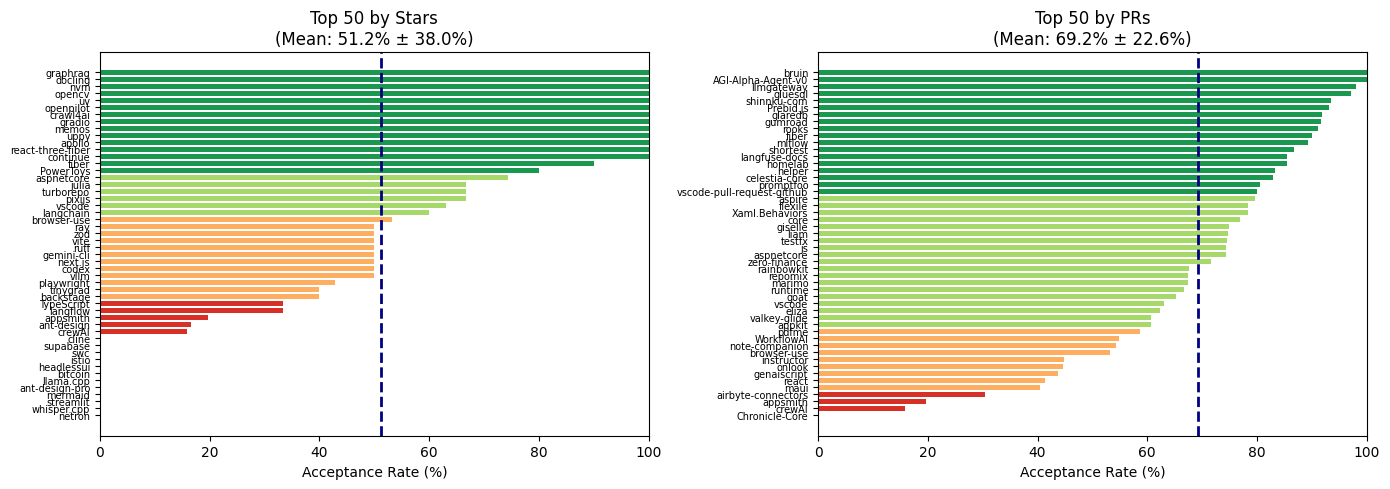

In [31]:
# Acceptance rate comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stars set
ax = axes[0]
data = stars_stats['per_repo_df'].sort_values('acceptance_rate', ascending=True)
colors = ['#d73027' if r < 40 else '#fdae61' if r < 60 else '#a6d96a' if r < 80 else '#1a9850'
          for r in data['acceptance_rate']]
ax.barh(range(len(data)), data['acceptance_rate'], color=colors)
ax.set_yticks(range(len(data)))
ax.set_yticklabels([n.split('/')[-1] for n in data['repo_name']], fontsize=7)
ax.axvline(x=stars_stats['mean_acceptance_rate'], color='navy', linestyle='--', linewidth=2)
ax.set_xlabel('Acceptance Rate (%)')
ax.set_title(f'Top 50 by Stars\n(Mean: {stars_stats["mean_acceptance_rate"]:.1f}% ± {stars_stats["std_acceptance_rate"]:.1f}%)')
ax.set_xlim(0, 100)

# PRs set
ax = axes[1]
data = prs_stats['per_repo_df'].sort_values('acceptance_rate', ascending=True)
colors = ['#d73027' if r < 40 else '#fdae61' if r < 60 else '#a6d96a' if r < 80 else '#1a9850'
          for r in data['acceptance_rate']]
ax.barh(range(len(data)), data['acceptance_rate'], color=colors)
ax.set_yticks(range(len(data)))
ax.set_yticklabels([n.split('/')[-1] for n in data['repo_name']], fontsize=7)
ax.axvline(x=prs_stats['mean_acceptance_rate'], color='navy', linestyle='--', linewidth=2)
ax.set_xlabel('Acceptance Rate (%)')
ax.set_title(f'Top 50 by PRs\n(Mean: {prs_stats["mean_acceptance_rate"]:.1f}% ± {prs_stats["std_acceptance_rate"]:.1f}%)')
ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()

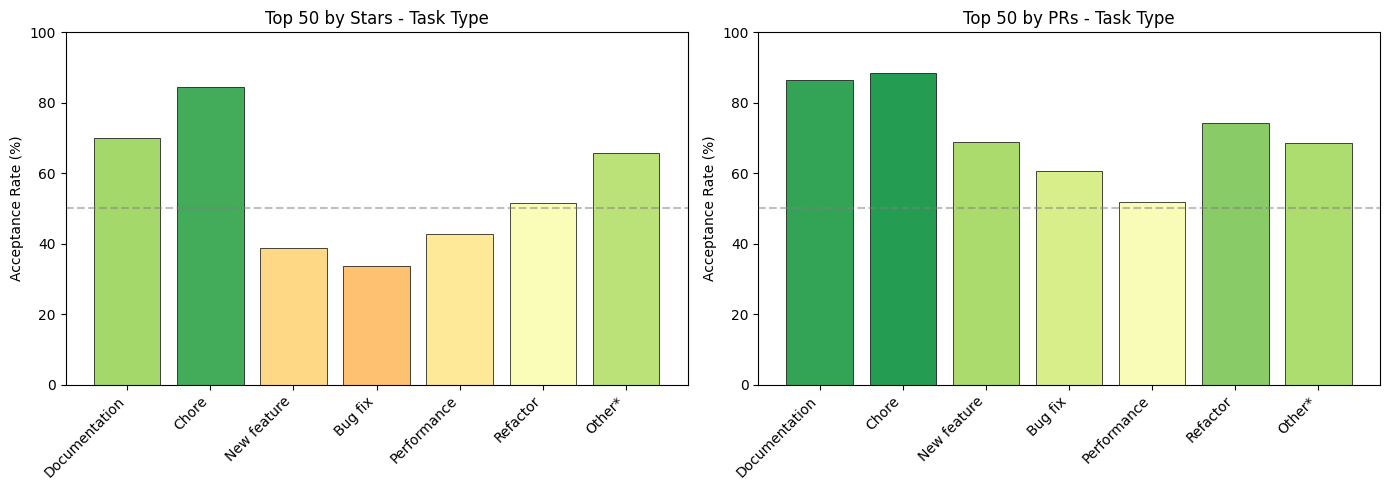

In [32]:
# Task type comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

task_order = ['Documentation', 'Chore', 'New feature', 'Bug fix', 'Performance', 'Refactor', 'Other*']

# Stars set
ax = axes[0]
data = stars_task_paper.set_index('task_type').reindex(task_order).reset_index()
colors = plt.cm.RdYlGn(data['acceptance_rate'] / 100)
bars = ax.bar(range(len(data)), data['acceptance_rate'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(data)))
ax.set_xticklabels(data['task_type'], rotation=45, ha='right')
ax.set_ylabel('Acceptance Rate (%)')
ax.set_title('Top 50 by Stars - Task Type')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

# PRs set
ax = axes[1]
data = prs_task_paper.set_index('task_type').reindex(task_order).reset_index()
colors = plt.cm.RdYlGn(data['acceptance_rate'] / 100)
bars = ax.bar(range(len(data)), data['acceptance_rate'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(data)))
ax.set_xticklabels(data['task_type'], rotation=45, ha='right')
ax.set_ylabel('Acceptance Rate (%)')
ax.set_title('Top 50 by PRs - Task Type')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

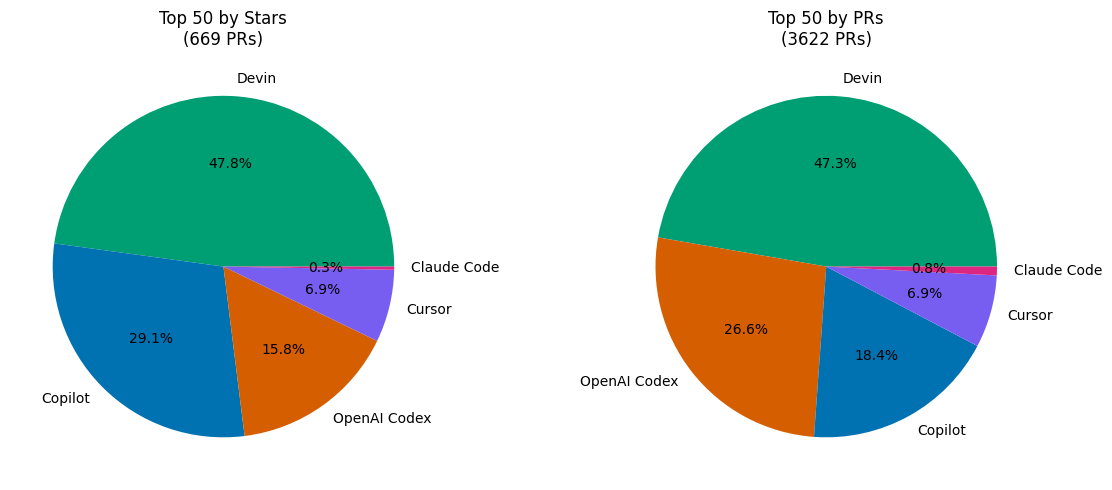

In [33]:
# Agent distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Stars set
ax = axes[0]
agent_colors = [COLOR_MAP.get(a.replace(' ', '_'), '#808080') for a in stars_agents['agent']]
ax.pie(stars_agents['count'], labels=stars_agents['agent'], autopct='%1.1f%%', colors=agent_colors)
ax.set_title(f'Top 50 by Stars\n({len(stars_pr_df)} PRs)')

# PRs set
ax = axes[1]
agent_colors = [COLOR_MAP.get(a.replace(' ', '_'), '#808080') for a in prs_agents['agent']]
ax.pie(prs_agents['count'], labels=prs_agents['agent'], autopct='%1.1f%%', colors=agent_colors)
ax.set_title(f'Top 50 by PRs\n({len(prs_pr_df)} PRs)')

plt.tight_layout()
plt.show()

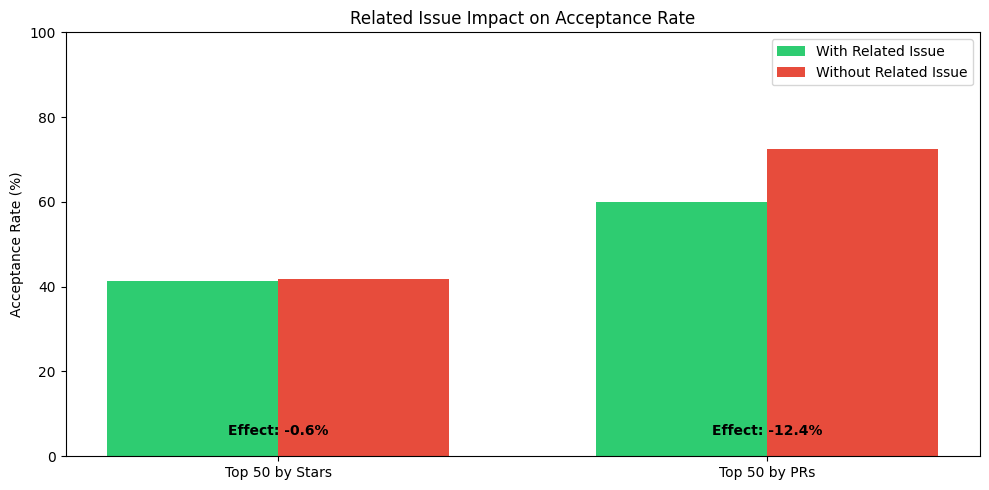

In [34]:
# Related issue impact
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(2)
width = 0.35

# With issue
with_rates = [stars_issue['with_issue']['rate'], prs_issue['with_issue']['rate']]
without_rates = [stars_issue['without_issue']['rate'], prs_issue['without_issue']['rate']]

bars1 = ax.bar(x - width/2, with_rates, width, label='With Related Issue', color='#2ecc71')
bars2 = ax.bar(x + width/2, without_rates, width, label='Without Related Issue', color='#e74c3c')

ax.set_ylabel('Acceptance Rate (%)')
ax.set_title('Related Issue Impact on Acceptance Rate')
ax.set_xticks(x)
ax.set_xticklabels(['Top 50 by Stars', 'Top 50 by PRs'])
ax.legend()
ax.set_ylim(0, 100)

# Add effect labels
for i, (effect, label) in enumerate([(stars_issue['effect'], 'Stars'), (prs_issue['effect'], 'PRs')]):
    ax.annotate(f'Effect: {effect:+.1f}%', xy=(i, 5), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()